In [ ]:
import requests, time, math, json, os
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [2]:
# 노드 특징 (4개의 노드, 각 노드는 2개의 특징을 가짐)
x = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0]], dtype=torch.float)

# 엣지 정보 (방향성이 없는 그래프이므로 양방향으로 연결)
# 0-1, 1-2, 2-3, 3-0 노드가 연결된 형태
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 3, 0],
                           [1, 0, 2, 1, 3, 2, 0, 3]], dtype=torch.long)

# 그래프 데이터 객체 생성
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[4, 2], edge_index=[2, 8])


In [9]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        # 첫 번째 GCN 레이어: 입력 특징 -> 히든 특징
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # 두 번째 GCN 레이어: 히든 특징 -> 출력 특징
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # 첫 번째 GCN 레이어 통과
        x = self.conv1(x, edge_index)
        # ReLU 활성화 함수 적용
        x = F.relu(x)
        # 두 번째 GCN 레이어 통과
        x = self.conv2(x, edge_index)
        
        return x

# 모델 초기화
# 입력 특징 차원: 2
# 히든 특징 차원: 16
# 출력 특징 차원: 3
model = GNN(in_channels=2, hidden_channels=16, out_channels=3)

print(model)

GNN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 3)
)


In [7]:
# 임의의 노드 레이블 (4개의 노드, 3개의 클래스 중 하나)
y = torch.tensor([0, 1, 2, 0], dtype=torch.long)

# 손실 함수와 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 모델 학습 (간단하게 100회 반복)
model.train()
for epoch in range(100):
    optimizer.zero_grad() # 기울기 초기화
    
    # 모델의 순전파 (Forward Pass)
    out = model(data.x, data.edge_index)
    
    # 손실 계산
    loss = criterion(out, y)
    
    # 역전파 (Backward Pass)
    loss.backward()
    
    # 가중치 업데이트
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

# 모델 예측
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)
    
print("\n최종 예측 결과 (각 노드의 3개 클래스에 대한 확률):")
print(pred)

Epoch [10/100], Loss: 1.0465
Epoch [20/100], Loss: 1.0403
Epoch [30/100], Loss: 1.0408
Epoch [40/100], Loss: 1.0407
Epoch [50/100], Loss: 1.0400
Epoch [60/100], Loss: 1.0391
Epoch [70/100], Loss: 1.0385
Epoch [80/100], Loss: 1.0380
Epoch [90/100], Loss: 1.0374
Epoch [100/100], Loss: 1.0368

최종 예측 결과 (각 노드의 3개 클래스에 대한 확률):
tensor([[0.7691, 0.1322, 0.1327],
        [0.8007, 0.1169, 0.1440],
        [0.8324, 0.1016, 0.1554],
        [0.8640, 0.0864, 0.1667]])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv  # GraphSAGE 모듈 불러오기
from torch_geometric.data import Data

# 노드 특징 (4개의 노드, 각 노드는 2개의 특징을 가짐)
x = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0]], dtype=torch.float)

# 엣지 정보 (방향성이 없는 그래프이므로 양방향으로 연결)
# 0-1, 1-2, 2-3, 3-0 노드가 연결된 형태
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 3, 0],
                           [1, 0, 2, 1, 3, 2, 0, 3]], dtype=torch.long)

# 그래프 데이터 객체 생성
data = Data(x=x, edge_index=edge_index)

# 임의의 노드 레이블 (4개의 노드, 3개의 클래스 중 하나)
y = torch.tensor([0, 1, 2, 0], dtype=torch.long)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        # 첫 번째 GraphSAGE 레이어: 입력 특징 -> 히든 특징
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        # 두 번째 GraphSAGE 레이어: 히든 특징 -> 출력 특징
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # 첫 번째 GraphSAGE 레이어 통과
        x = self.conv1(x, edge_index)
        # ReLU 활성화 함수 적용
        x = F.relu(x)
        # 두 번째 GraphSAGE 레이어 통과
        x = self.conv2(x, edge_index)
        
        return x

# 모델 초기화
model = GraphSAGE(in_channels=2, hidden_channels=16, out_channels=3)

print("모델 구조:\n", model)

모델 구조:
 GraphSAGE(
  (conv1): SAGEConv(2, 16, aggr=mean)
  (conv2): SAGEConv(16, 3, aggr=mean)
)


In [9]:
# 손실 함수와 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 모델 학습 (간단하게 100회 반복)
model.train()
for epoch in range(100):
    optimizer.zero_grad() # 기울기 초기화
    
    # 모델의 순전파 (Forward Pass)
    out = model(data.x, data.edge_index)
    
    # 손실 계산
    loss = criterion(out, y)
    
    # 역전파 (Backward Pass)
    loss.backward()
    
    # 가중치 업데이트
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

# 모델 예측
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)
    
print("\n최종 예측 결과 (각 노드의 3개 클래스에 대한 확률):")
print(pred)

Epoch [10/100], Loss: 1.0196
Epoch [20/100], Loss: 0.6246
Epoch [30/100], Loss: 0.3404
Epoch [40/100], Loss: 0.1748
Epoch [50/100], Loss: 0.0918
Epoch [60/100], Loss: 0.0532
Epoch [70/100], Loss: 0.0343
Epoch [80/100], Loss: 0.0245
Epoch [90/100], Loss: 0.0186
Epoch [100/100], Loss: 0.0149

최종 예측 결과 (각 노드의 3개 클래스에 대한 확률):
tensor([[ 3.3106, -2.1530, -1.3290],
        [ 1.6613,  5.8538, -1.8779],
        [ 1.6316, -2.6715,  5.8186],
        [ 4.1316, -0.6677, -0.9994]])


In [2]:
import requests
import json
import time

# --- Etherscan API Key와 토큰 정보 설정 ---
# Etherscan 웹사이트에서 발급받은 API Key를 입력하세요.
# (무료 키는 제한된 요청 횟수만 제공합니다.)
API_KEY = "6K89I8GZPJ7W1QP65KR9W4XHTHA8MMKZ7P"

# 논문에서 사용된 PicaArtMoney 토큰의 컨트랙트 주소
TOKEN_CONTRACT_ADDRESS = "0xdac17f958d2ee523a2206206994597c13d831ec7"  # 예시 주소, 실제 주소 확인 필요

# 데이터 저장을 위한 파일명
OUTPUT_FILE = "picaartmoney_transactions.json"

# --- 데이터 수집 함수 정의 ---
def fetch_all_token_transactions(contract_address, api_key):
    """
    Etherscan API를 사용하여 특정 ERC-20 토큰의 모든 거래 내역을 수집합니다.
    """
    transactions = []
    page = 1
    offset = 10000  # Etherscan API의 최대 페이지당 레코드 수

    print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 데이터 수집을 시작합니다...")

    while True:
        url = (
            f"https://api.etherscan.io/api?module=account&action=tokentx"
            f"&contractaddress={contract_address}&page={page}&offset={offset}&sort=asc&apikey={api_key}"
        )
        
        try:
            response = requests.get(url)
            data = response.json()

            if data["status"] == "1":
                results = data["result"]
                if not results:
                    print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 모든 페이지를 가져왔습니다. 수집 종료.")
                    break
                
                transactions.extend(results)
                print(f"[{time.strftime('%H:%M:%S', time.localtime())}] {page} 페이지 {len(results)}개 트랜잭션 수집 완료.")
                page += 1
                time.sleep(1)  # API 요청 제한 방지를 위해 1초 대기

            else:
                print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 오류 발생: {data['message']}")
                break
        
        except requests.exceptions.RequestException as e:
            print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 네트워크 오류 발생: {e}")
            break

    return transactions

# --- 메인 실행 로직 ---
if __name__ == "__main__":
    all_transactions = fetch_all_token_transactions(TOKEN_CONTRACT_ADDRESS, API_KEY)
    
    if all_transactions:
        # 수집된 데이터를 JSON 파일로 저장
        with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
            json.dump(all_transactions, f, indent=4)
        print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 총 {len(all_transactions)}개의 트랜잭션이 '{OUTPUT_FILE}' 파일에 저장되었습니다.")

[12:58:38] 데이터 수집을 시작합니다...
[12:58:45] 1 페이지 10000개 트랜잭션 수집 완료.
[12:58:47] 오류 발생: Result window is too large, PageNo x Offset size must be less than or equal to 10000
[12:58:47] 총 10000개의 트랜잭션이 'picaartmoney_transactions.json' 파일에 저장되었습니다.


In [1]:
from dotenv import load_dotenv
import os

# .env 파일 로드
load_dotenv()

True

In [ ]:
import requests
import json
import time

# --- Etherscan API Key와 토큰 정보 설정 ---
# Etherscan 웹사이트에서 발급받은 API Key를 입력하세요.
API_KEY = os.getenv('ETHEREUM_API_KEY')

# USDT 토큰의 컨트랙트 주소 (이더리움 네트워크)
TOKEN_CONTRACT_ADDRESS = os.getenv('ETHEREUM_TOKEN_CONTRACT_ADDRESS')

# 데이터 저장을 위한 파일명
OUTPUT_FILE = "usdt_transactions_by_block.json"

# --- 데이터 수집 함수 정의 ---
def fetch_transactions_by_block(contract_address, api_key, start_block, end_block):
    """
    지정된 블록 범위 내의 모든 ERC-20 토큰 거래 내역을 수집합니다.
    """
    transactions = []
    
    # Etherscan API는 page/offset 대신 startblock/endblock을 주로 사용
    url = (
        f"https://api.etherscan.io/api?module=account&action=tokentx"
        f"&contractaddress={contract_address}&startblock={start_block}"
        f"&endblock={end_block}&sort=asc&apikey={api_key}"
    )
    
    try:
        response = requests.get(url)
        data = response.json()

        if data["status"] == "1":
            results = data["result"]
            transactions.extend(results)
            print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 블록 {start_block} ~ {end_block} 범위에서 {len(results)}개 트랜잭션 수집 완료.")
        else:
            print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 오류 발생: {data['message']}")
            # 오류가 발생해도 다음 블록 범위로 진행
            
    except requests.exceptions.RequestException as e:
        print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 네트워크 오류 발생: {e}")
        
    return transactions

# --- 메인 실행 로직 ---
if __name__ == "__main__":
    
    # 논문에 따라, 블록 범위를 설정하고 나눠서 호출
    # 예시: 시작 블록과 종료 블록은 실제 데이터에 맞게 변경 필요
    START_BLOCK_RANGE = 12000000 
    END_BLOCK_RANGE = 12100000
    BLOCK_INTERVAL = 1000 # 한 번에 가져올 블록 간격
    
    all_transactions = []
    
    print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 블록 {START_BLOCK_RANGE}부터 {END_BLOCK_RANGE}까지 데이터 수집을 시작합니다.")

    # 블록 범위를 일정 간격으로 나누어 API 호출
    for block_num in range(START_BLOCK_RANGE, END_BLOCK_RANGE, BLOCK_INTERVAL):
        current_end_block = block_num + BLOCK_INTERVAL - 1
        # Etherscan은 최신 블록을 'latest'로 지정 가능
        if current_end_block > END_BLOCK_RANGE:
            current_end_block = END_BLOCK_RANGE
            
        transactions = fetch_transactions_by_block(TOKEN_CONTRACT_ADDRESS, API_KEY, block_num, current_end_block)
        all_transactions.extend(transactions)
        
        # API 요청 제한 방지를 위해 잠시 대기 (무료 플랜: 1초에 5회)
        time.sleep(0.3) 
        
    if all_transactions:
        # 수집된 데이터를 JSON 파일로 저장
        with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
            json.dump(all_transactions, f, indent=4)
        print(f"[{time.strftime('%H:%M:%S', time.localtime())}] 총 {len(all_transactions)}개의 트랜잭션이 '{OUTPUT_FILE}' 파일에 저장되었습니다.")

[13:38:56] 블록 12000000부터 12100000까지 데이터 수집을 시작합니다.
[13:39:00] 블록 12000000 ~ 12000999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:03] 블록 12001000 ~ 12001999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:06] 블록 12002000 ~ 12002999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:10] 블록 12003000 ~ 12003999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:13] 블록 12004000 ~ 12004999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:16] 블록 12005000 ~ 12005999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:20] 블록 12006000 ~ 12006999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:23] 블록 12007000 ~ 12007999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:26] 블록 12008000 ~ 12008999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:30] 블록 12009000 ~ 12009999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:33] 블록 12010000 ~ 12010999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:36] 블록 12011000 ~ 12011999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:40] 블록 12012000 ~ 12012999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:43] 블록 12013000 ~ 12013999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:47] 블록 12014000 ~ 12014999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:50] 블록 12015000 ~ 12015999 범위에서 10000개 트랜잭션 수집 완료.
[13:39:53] 블록 1201600

In [1]:
import pandas as pd
import json

# 저장된 JSON 파일 이름
file_name = "usdt_transactions_by_block.json"

try:
    # JSON 파일 읽기
    with open(file_name, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 데이터를 Pandas DataFrame으로 변환
    df = pd.DataFrame(data)

    # 데이터프레임의 첫 5개 행 출력하여 확인
    print("DataFrame 변환 성공!")
    print(df.head())

    # 데이터프레임 정보 요약
    print("\nDataFrame 정보:")
    df.info()

except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을 찾을 수 없습니다.")
except Exception as e:
    print(f"데이터를 불러오는 중 오류가 발생했습니다: {e}")

DataFrame 변환 성공!
  blockNumber   timeStamp                                               hash  \
0    12000000  1615234816  0xe534a95bbda4c029c76242f26c3a80936f611d1c7e8e...   
1    12000000  1615234816  0xd15e923e03b77d836ca831a70d9721642953ba5fe775...   
2    12000000  1615234816  0xdcc1100a1d6a698da53f6740e1852a09e2424880dd67...   
3    12000000  1615234816  0x2f31f5065b2c685f739c1ef0ec4fb6bfb63c6d82e260...   
4    12000000  1615234816  0xea52de8abfc71e6c5066217253b596eeb4d285395cf9...   

    nonce                                          blockHash  \
0   17865  0x3c9c46a46b17361cd1ac3ed3401c9a268095c1810bf9...   
1       1  0x3c9c46a46b17361cd1ac3ed3401c9a268095c1810bf9...   
2  445080  0x3c9c46a46b17361cd1ac3ed3401c9a268095c1810bf9...   
3    4619  0x3c9c46a46b17361cd1ac3ed3401c9a268095c1810bf9...   
4  601786  0x3c9c46a46b17361cd1ac3ed3401c9a268095c1810bf9...   

                                         from  \
0  0x9bc8d5842f9005593a7fc16944ce2008c1c49384   
1  0xa2a98f9b899692

In [3]:
df.count()

blockNumber          1000000
timeStamp            1000000
hash                 1000000
nonce                1000000
blockHash            1000000
from                 1000000
contractAddress      1000000
to                   1000000
value                1000000
tokenName            1000000
tokenSymbol          1000000
tokenDecimal         1000000
transactionIndex     1000000
gas                  1000000
gasPrice             1000000
gasUsed              1000000
cumulativeGasUsed    1000000
input                1000000
methodId             1000000
functionName         1000000
confirmations        1000000
dtype: int64

In [19]:
import torch
import torch_geometric.data as Data
from torch_geometric.nn import GATConv
import pandas as pd
import numpy as np
import json
import networkx as nx

# --- 1. 데이터 불러오기 및 그래프 전처리 ---
# usdt_transactions_by_block.json 파일을 불러와서 Pandas DataFrame으로 변환
def load_and_preprocess_data(file_path):
    """
    JSON 파일을 불러와서 그래프 데이터로 변환합니다.
    (노드: 지갑 주소, 엣지: 거래)
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            transactions_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

    df = pd.DataFrame(transactions_data)
    
    # from, to, value를 포함하는 엣지 목록 생성
    # 논문에서는 'from'과 'to' 지갑 주소를 노드로, 거래를 엣지로 간주
    edges = df[['from', 'to']].values.tolist()
    
    # 고유한 지갑 주소(노드) 목록 생성
    unique_addresses = sorted(list(set(df['from'].tolist() + df['to'].tolist())))
    
    # 주소-인덱스 매핑 딕셔너리 생성 (모델 입력에 필요)
    address_to_idx = {addr: i for i, addr in enumerate(unique_addresses)}
    
    # 그래프 엣지(Edge)를 Tensor로 변환
    # 거래가 양방향으로 발생할 수 있으므로, 엣지 목록을 [from, to] 형태로 변환
    edge_index = torch.tensor([[address_to_idx[edge[0]], address_to_idx[edge[1]]] for edge in edges], dtype=torch.long).t().contiguous()

    # 노드 피처(Node Features) 생성: 논문에서는 트랜잭션 수, 총 거래량 등을 사용
    # 여기서는 간단한 예시로 각 주소의 in-degree와 out-degree를 피처로 사용
    num_nodes = len(unique_addresses)
    x = torch.zeros(num_nodes, 2) # (in_degree, out_degree)
    
    # NetworkX를 사용해 간편하게 degree 계산
    G = nx.from_pandas_edgelist(df, source='from', target='to', create_using=nx.DiGraph())
    
    for i, addr in enumerate(unique_addresses):
        if addr in G:
            x[i, 0] = G.in_degree(addr)  # in-degree
            x[i, 1] = G.out_degree(addr) # out-degree

    # PyG(PyTorch Geometric) Data 객체 생성
    data = Data.Data(x=x, edge_index=edge_index)
    
    return data, unique_addresses


# --- 2. GAT(Graph Attention Network) 모델 정의 ---
# 비지도 학습(Autoencoder) 방식의 GAT 모델
class GATAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GATAutoencoder, self).__init__()
        # 인코더: 입력 특징을 압축하여 저차원 임베딩으로 변환
        self.gat_encoder = GATConv(in_channels, hidden_channels)
        # 디코더: 임베딩을 다시 원본 그래프 구조로 재구성
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * 2, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1) # 엣지 존재 확률 예측
        )

    def forward(self, x, edge_index):
        # 인코더
        z = self.gat_encoder(x, edge_index)
        
        # 디코더: 엣지의 존재를 예측
        # 각 엣지의 노드 쌍 (u, v)에 대한 임베딩을 합쳐서 예측
        row, col = edge_index
        edge_embeddings = torch.cat([z[row], z[col]], dim=-1)
        reconstruction = self.decoder(edge_embeddings).sigmoid()
        
        return z, reconstruction

# --- 3. 모델 학습 및 이상 거래 탐지 ---
def detect_anomalies(data, model, epochs=100):
    """
    GAT Autoencoder 모델을 학습시키고, 재구성 오차를 통해 이상 거래를 탐지합니다.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 엣지 레이블(정답) 생성: 모든 엣지가 존재하므로 1로 설정
    edge_label = torch.ones(data.edge_index.size(1), 1)
    
    # 손실 함수: 이진 크로스 엔트로피 손실 (BCE Loss)
    criterion = torch.nn.BCELoss()
    
    print("GAT 모델 학습 시작...")
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # 순전파
        _, reconstruction = model(data.x, data.edge_index)
        
        # 손실 계산
        loss = criterion(reconstruction, edge_label)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03d}, Loss: {loss.item():.4f}')
            
    print("GAT 모델 학습 완료.")
    
    # 이상 탐지
    model.eval()
    with torch.no_grad():
        _, reconstruction = model(data.x, data.edge_index)
        
        # 재구성 오차(Reconstruction Error) 계산
        # 원본 엣지 레이블(1)과 재구성된 값(0~1)의 차이
        reconstruction_error = torch.abs(edge_label - reconstruction).squeeze()
        
        # 재구성 오차를 기준으로 상위 10%를 이상 거래로 간주
        threshold = torch.quantile(reconstruction_error, 0.9)
        anomalies_indices = (reconstruction_error > threshold).nonzero(as_tuple=True)[0]
        
    return reconstruction_error, anomalies_indices


# --- 4. 메인 실행 로직 ---
if __name__ == "__main__":
    file_path = 'usdt_transactions_by_block.json'
    
    # 1. 데이터 전처리 및 그래프 객체 생성
    graph_data, addresses = load_and_preprocess_data(file_path)
    if graph_data is None:
        exit()
        
    print(f"\n그래프 데이터 생성 완료. 총 노드: {graph_data.num_nodes}, 총 엣지: {graph_data.num_edges}")

    # 2. 모델 인스턴스 생성
    in_channels = graph_data.num_node_features
    hidden_channels = 64
    out_channels = 32
    
    model = GATAutoencoder(in_channels, hidden_channels, out_channels)
    
    # 3. 이상 탐지 실행
    reconstruction_errors, anomalies_indices = detect_anomalies(graph_data, model)
    
    # 4. 결과 분석 및 출력
    print("\n--- 이상 거래 탐지 결과 ---")
    if len(anomalies_indices) > 0:
        anomalies_info = []
        df = pd.read_json(file_path)
        
        # 이상 거래 엣지(edge) 정보 가져오기
        anomalous_edges = graph_data.edge_index.t()[anomalies_indices]
        
        for edge_tuple in anomalous_edges.tolist():
            from_addr = addresses[edge_tuple[0]]
            to_addr = addresses[edge_tuple[1]]
            
            # 원본 DataFrame에서 해당 거래 정보 찾기
            # 'from'과 'to' 주소를 기준으로 필터링하여 해당 거래의 세부 정보(value, hash 등) 추출
            original_transactions = df[(df['from'] == from_addr) & (df['to'] == to_addr)]
            
            if not original_transactions.empty:
                # 첫 번째 일치하는 거래의 해시와 값만 가져옴 (같은 엣지라도 여러 거래가 있을 수 있음)
                tx_hash = original_transactions.iloc[0]['hash']
                value = int(original_transactions.iloc[0]['value']) / 10**18  # USDT는 6 decimal
                
                print(f"이상 거래 탐지: From={from_addr[:8]}..., To={to_addr[:8]}..., Value={value:.2f} USDT")
                print(f" - Transaction Hash: {tx_hash}")

    else:
        print("이상 거래가 탐지되지 않았습니다. 데이터를 더 많이 확보하거나 파라미터를 조정해보세요.")

이상 거래 탐지: From=0xacdd8a..., To=0x691e68..., Value=0.00 USDT
 - Transaction Hash: 0x5b9e2f2d3f339dd50cc455fae35e145cb3c4053853e4e0b42e4b874cfe6d9836
이상 거래 탐지: From=0x6b2b83..., To=0xcb48d9..., Value=0.00 USDT
 - Transaction Hash: 0xaddbdae7b4b354f3df58649f3040c9e26ba1c13b478020fb54ac99c608b9cdab
이상 거래 탐지: From=0x4d0863..., To=0x3b112f..., Value=0.00 USDT
 - Transaction Hash: 0x95d914da5f54cadd0eb5ab2421d8b0b0fc4bc008bab12b5cd9239a056afeab4a
이상 거래 탐지: From=0x8bb534..., To=0x13d252..., Value=0.00 USDT
 - Transaction Hash: 0x49567b78cd9e89fd6a08f473929c5cb1f253c81b85dc113c565f39b4e1b26921
이상 거래 탐지: From=0x30648f..., To=0x1bdbb9..., Value=0.00 USDT
 - Transaction Hash: 0x15ba62f27a9d8f3c17a02e709d1171173176fd83c2f61622c82cd80775a3f703
이상 거래 탐지: From=0x4d5777..., To=0x2f8f35..., Value=0.00 USDT
 - Transaction Hash: 0x2d76201541422020f4c23b8ad52de161563f82524d4b357ae630eb427aa96cd0
이상 거래 탐지: From=0x93af41..., To=0xa2690f..., Value=0.00 USDT
 - Transaction Hash: 0x83ab1c2ab09aec6064f80377b7d4e

In [20]:
import smtplib
from email.mime.text import MIMEText

# Gmail 계정 정보
EMAIL = "kgwasd@gmail.com"
PASSWORD = "pltd oyjw gjyz fuhi"
TO = "kgwasd@gmail.com"

def send_mail():
    msg = MIMEText("Python 코드 실행이 완료되었습니다!0905")
    msg['Subject'] = "실행 완료 알림"
    msg['From'] = EMAIL
    msg['To'] = TO

    # Gmail SMTP 서버 연결
    with smtplib.SMTP('smtp.gmail.com', 587) as smtp:
        smtp.starttls()  # TLS 암호화
        smtp.login(EMAIL, PASSWORD)
        smtp.send_message(msg)

send_mail()

In [21]:
# pc종료
import os
os.system("shutdown /s /t 30")

0

In [ ]:
import torch
import torch_geometric.data as Data
from torch_geometric.nn import SAGEConv
import pandas as pd
import numpy as np
import json
import networkx as nx

# --- 1. 데이터 불러오기 및 그래프 전처리 ---
# usdt_transactions_by_block.json 파일을 불러와서 Pandas DataFrame으로 변환
def load_and_preprocess_data(file_path):
    """
    JSON 파일을 불러와서 그래프 데이터로 변환합니다.
    (노드: 지갑 주소, 엣지: 거래)
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            transactions_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

    df = pd.DataFrame(transactions_data)
    
    # from, to, value를 포함하는 엣지 목록 생성
    edges = df[['from', 'to']].values.tolist()
    
    # 고유한 지갑 주소(노드) 목록 생성
    unique_addresses = sorted(list(set(df['from'].tolist() + df['to'].tolist())))
    
    # 주소-인덱스 매핑 딕셔너리 생성 (모델 입력에 필요)
    address_to_idx = {addr: i for i, addr in enumerate(unique_addresses)}
    
    # 그래프 엣지(Edge)를 Tensor로 변환
    edge_index = torch.tensor([[address_to_idx[edge[0]], address_to_idx[edge[1]]] for edge in edges], dtype=torch.long).t().contiguous()

    # 노드 피처(Node Features) 생성
    num_nodes = len(unique_addresses)
    x = torch.zeros(num_nodes, 2) # (in_degree, out_degree)
    
    # NetworkX를 사용해 간편하게 degree 계산
    G = nx.from_pandas_edgelist(df, source='from', target='to', create_using=nx.DiGraph())
    
    for i, addr in enumerate(unique_addresses):
        if addr in G:
            x[i, 0] = G.in_degree(addr)  # in-degree
            x[i, 1] = G.out_degree(addr) # out-degree

    # PyG(PyTorch Geometric) Data 객체 생성
    data = Data.Data(x=x, edge_index=edge_index)
    
    return data, unique_addresses


# --- 2. GraphSAGE 모델 정의 ---
# 비지도 학습(Autoencoder) 방식의 GraphSAGE 모델
class GraphSAGEAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEAutoencoder, self).__init__()
        # 인코더: 입력 특징을 압축하여 저차원 임베딩으로 변환
        self.sage_encoder = SAGEConv(in_channels, hidden_channels)
        # 디코더: 임베딩을 다시 원본 그래프 구조로 재구성
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * 2, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1) # 엣지 존재 확률 예측
        )

    def forward(self, x, edge_index):
        # 인코더
        z = self.sage_encoder(x, edge_index)
        
        # 디코더: 엣지의 존재를 예측
        row, col = edge_index
        edge_embeddings = torch.cat([z[row], z[col]], dim=-1)
        reconstruction = self.decoder(edge_embeddings).sigmoid()
        
        return z, reconstruction

# --- 3. 모델 학습 및 이상 거래 탐지 ---
def detect_anomalies_graphsage(data, model, epochs=100):
    """
    GraphSAGE Autoencoder 모델을 학습시키고, 재구성 오차를 통해 이상 거래를 탐지합니다.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 엣지 레이블(정답) 생성: 모든 엣지가 존재하므로 1로 설정
    edge_label = torch.ones(data.edge_index.size(1), 1)
    
    # 손실 함수: 이진 크로스 엔트로피 손실 (BCE Loss)
    criterion = torch.nn.BCELoss()
    
    print("GraphSAGE 모델 학습 시작...")
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # 순전파
        _, reconstruction = model(data.x, data.edge_index)
        
        # 손실 계산
        loss = criterion(reconstruction, edge_label)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03d}, Loss: {loss.item():.4f}')
            
    print("GraphSAGE 모델 학습 완료.")
    
    # 이상 탐지
    model.eval()
    with torch.no_grad():
        _, reconstruction = model(data.x, data.edge_index)
        
        # 재구성 오차(Reconstruction Error) 계산
        reconstruction_error = torch.abs(edge_label - reconstruction).squeeze()
        
        # 재구성 오차를 기준으로 상위 10%를 이상 거래로 간주
        threshold = torch.quantile(reconstruction_error, 0.9)
        anomalies_indices = (reconstruction_error > threshold).nonzero(as_tuple=True)[0]
        
    return reconstruction_error, anomalies_indices


# --- 4. 메인 실행 로직 ---
if __name__ == "__main__":
    file_path = 'usdt_transactions_by_block.json'
    
    # 1. 데이터 전처리 및 그래프 객체 생성
    graph_data, addresses = load_and_preprocess_data(file_path)
    if graph_data is None:
        exit()
        
    print(f"\n그래프 데이터 생성 완료. 총 노드: {graph_data.num_nodes}, 총 엣지: {graph_data.num_edges}")

    # 2. 모델 인스턴스 생성
    in_channels = graph_data.num_node_features
    hidden_channels = 64
    out_channels = 32
    
    model = GraphSAGEAutoencoder(in_channels, hidden_channels, out_channels)
    
    # 3. 이상 탐지 실행
    reconstruction_errors, anomalies_indices = detect_anomalies_graphsage(graph_data, model)
    
    # 4. 결과 분석 및 출력
    print("\n--- 이상 거래 탐지 결과 (GraphSAGE) ---")
    if len(anomalies_indices) > 0:
        df = pd.read_json(file_path)
        
        # 이상 거래 엣지(edge) 정보 가져오기
        anomalous_edges = graph_data.edge_index.t()[anomalies_indices]
        
        for edge_tuple in anomalous_edges.tolist():
            from_addr = addresses[edge_tuple[0]]
            to_addr = addresses[edge_tuple[1]]
            
            # 원본 DataFrame에서 해당 거래 정보 찾기
            original_transactions = df[(df['from'] == from_addr) & (df['to'] == to_addr)]
            
            if not original_transactions.empty:
                # 첫 번째 일치하는 거래의 해시와 값만 가져옴
                tx_hash = original_transactions.iloc[0]['hash']
                value = int(original_transactions.iloc[0]['value']) / 10**18
                
                print(f"이상 거래 탐지: From={from_addr[:8]}..., To={to_addr[:8]}..., Value={value:.2f} USDT")
                print(f" - Transaction Hash: {tx_hash}")

    else:
        print("이상 거래가 탐지되지 않았습니다. 데이터를 더 많이 확보하거나 파라미터를 조정해보세요.")

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
# 1. 그래프 구조 시각화 (노드와 엣지, 노드의 특성)

def plot_graph_structure_detailed():
    G = nx.DiGraph()
    G.add_nodes_from([
        ("A", {"feature": "Feature_A"}),
        ("B", {"feature": "Feature_B"}),
        ("C", {"feature": "Feature_C"}),
        ("D", {"feature": "Feature_D"}),
        ("E", {"feature": "Feature_E"}),
        ("F", {"feature": "Feature_F"}),
        ("G", {"feature": "Feature_G"}),
        ("H", {"feature": "Feature_H"})
    ])
    G.add_edges_from([
        ("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"),
        ("D", "F"), ("E", "F"), ("E", "G"), ("F", "H"), ("G", "H")
    ])
   
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, arrows=True)
    labels = {node: f"{node}\n{data['feature']}" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    plt.title("1. Graph Structure: Nodes with Features and Directed Edges")
    plt.show()

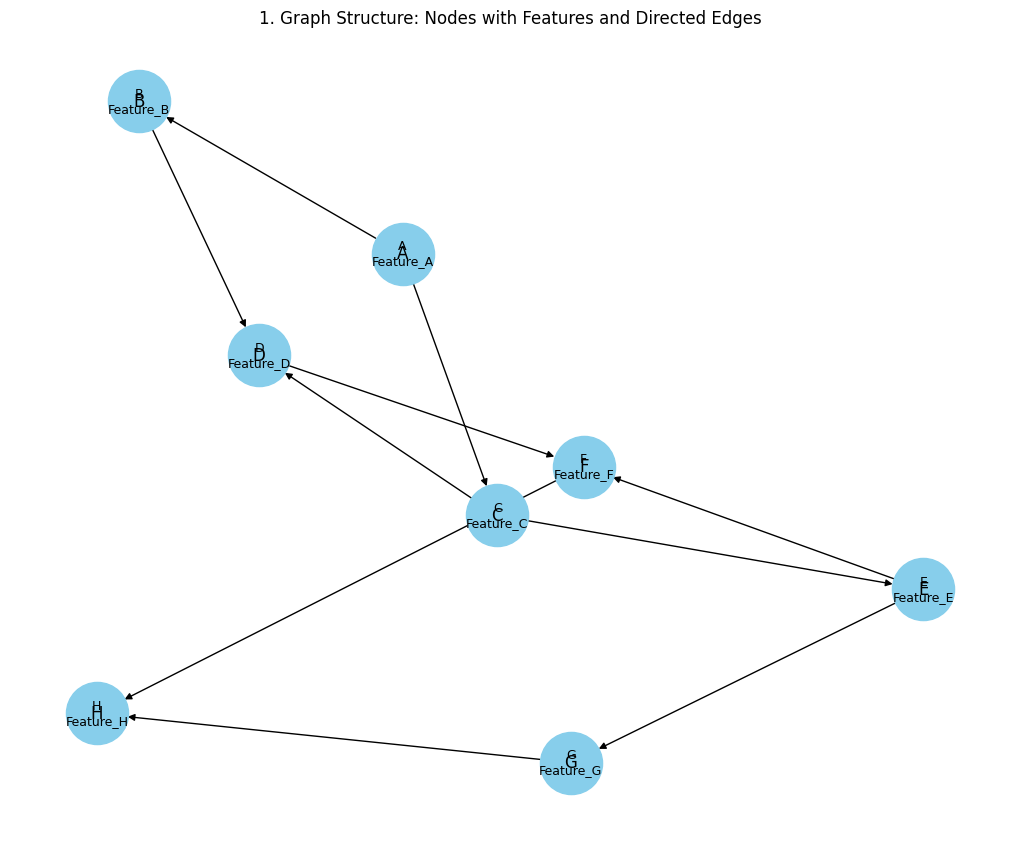

In [7]:
plot_graph_structure_detailed()

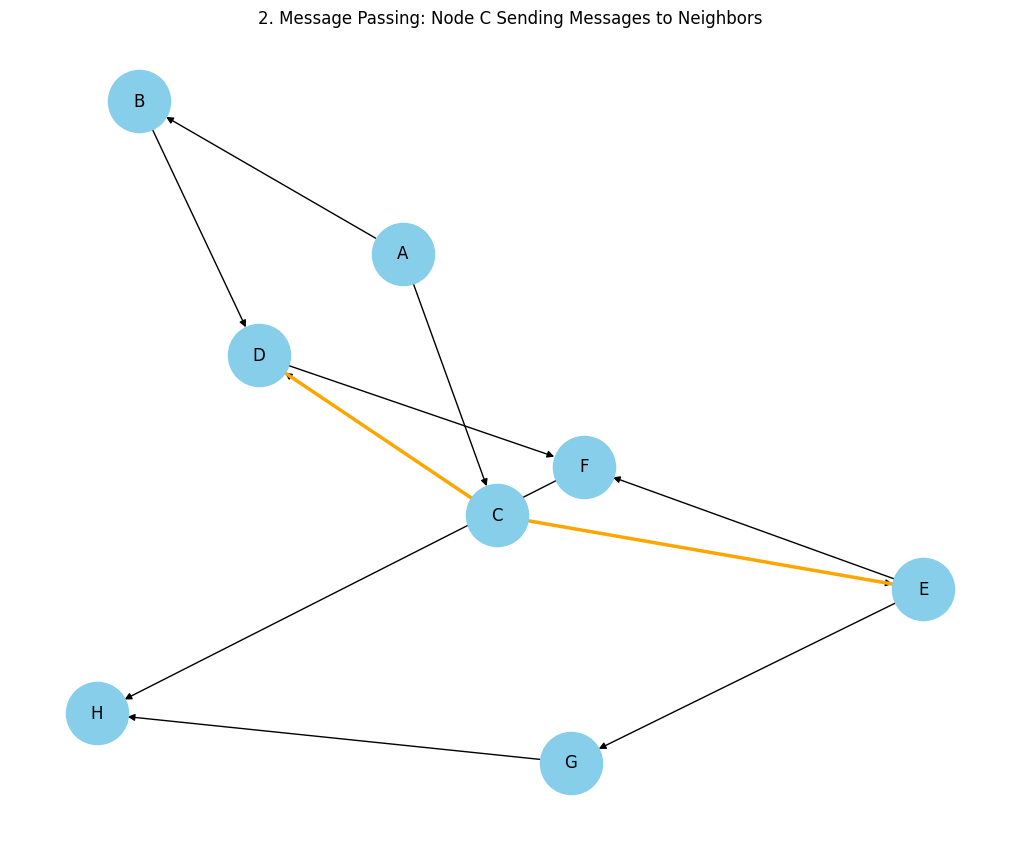

In [8]:
# 2. 메시지 전달 시각화 (특정 노드에서 이웃 노드로 메시지 전송)
def plot_message_passing_detailed():
    G = nx.DiGraph()
    G.add_edges_from([
        ("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"),
        ("D", "F"), ("E", "F"), ("E", "G"), ("F", "H"), ("G", "H")
    ])
    pos = nx.spring_layout(G, seed=42)
   
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, arrows=True)
   
    # "C"가 이웃 노드들로 메시지 전달
    nx.draw_networkx_edges(G, pos, edgelist=[("C", "D"), ("C", "E")],
                           width=2.5, edge_color='orange', arrows=True)
    plt.title("2. Message Passing: Node C Sending Messages to Neighbors")
    plt.show()

plot_message_passing_detailed()

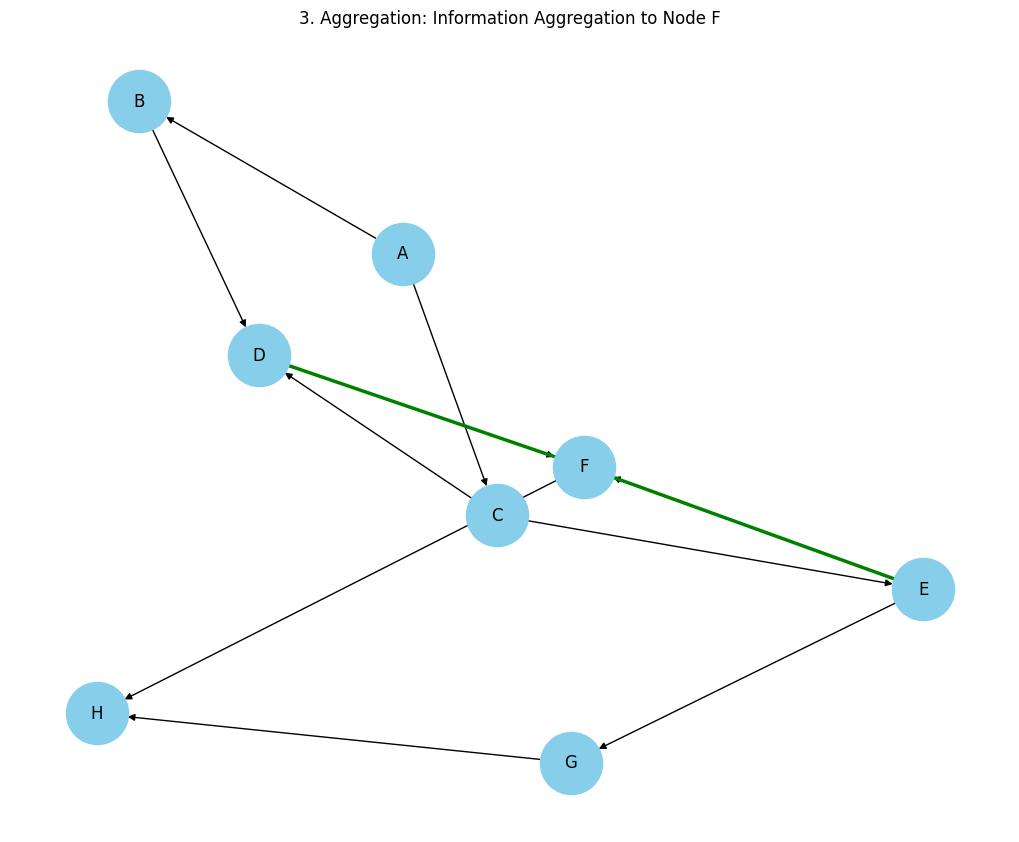

In [9]:
# 3. 집계 시각화 (노드로부터 받은 정보를 집계)
def plot_aggregation_detailed():
    G = nx.DiGraph()
    G.add_edges_from([
        ("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"),
        ("D", "F"), ("E", "F"), ("E", "G"), ("F", "H"), ("G", "H")
    ])
    pos = nx.spring_layout(G, seed=42)
   
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, arrows=True)
   
    # "F"가 이웃 노드들로부터 정보 집계
    nx.draw_networkx_edges(G, pos, edgelist=[("D", "F"), ("E", "F")],
                           width=2.5, edge_color='green', arrows=True)
    plt.title("3. Aggregation: Information Aggregation to Node F")
    plt.show()

plot_aggregation_detailed()

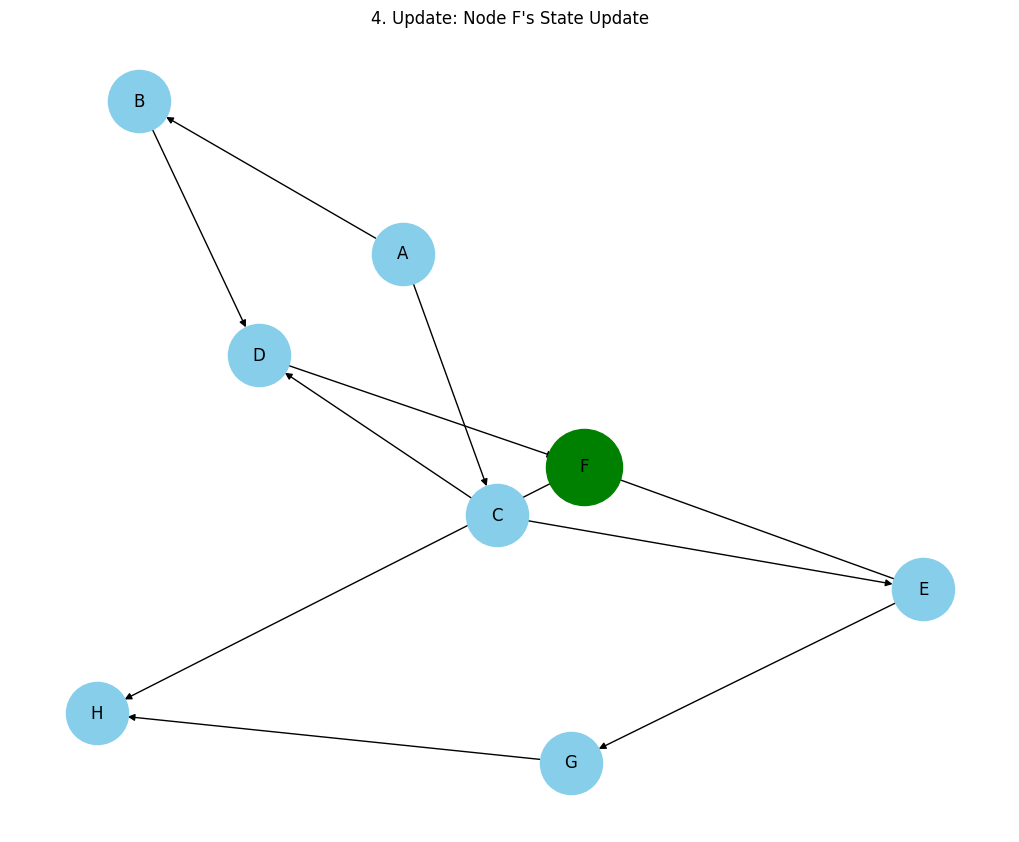

In [10]:
# 4. 갱신 시각화 (노드의 상태 업데이트)

def plot_update_detailed():
    G = nx.DiGraph()
    G.add_edges_from([
        ("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"),
        ("D", "F"), ("E", "F"), ("E", "G"), ("F", "H"), ("G", "H")
    ])
    pos = nx.spring_layout(G, seed=42)
   
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, arrows=True)
   
    # "F" 노드의 상태 갱신
    nx.draw_networkx_nodes(G, pos, nodelist=["F"], node_color='green', node_size=3000)
    plt.title("4. Update: Node F's State Update")
    plt.show()

plot_update_detailed()

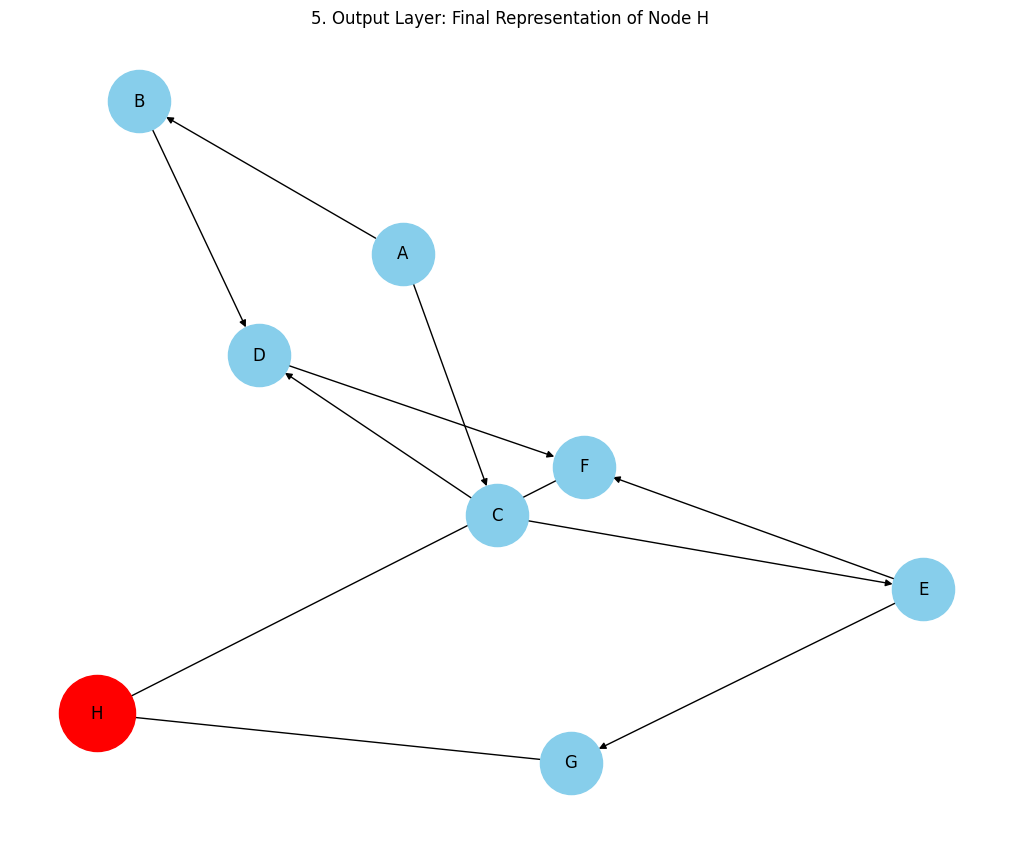

In [11]:
# 5. 출력 레이어 시각화 (최종 상태 출력)

def plot_output_layer_detailed():
    G = nx.DiGraph()
    G.add_edges_from([
        ("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"),
        ("D", "F"), ("E", "F"), ("E", "G"), ("F", "H"), ("G", "H")
    ])
    pos = nx.spring_layout(G, seed=42)
   
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, arrows=True)
   
    # "H" 노드의 최종 출력
    nx.draw_networkx_nodes(G, pos, nodelist=["H"], node_color='red', node_size=3000)
    plt.title("5. Output Layer: Final Representation of Node H")
    plt.show()

plot_output_layer_detailed()

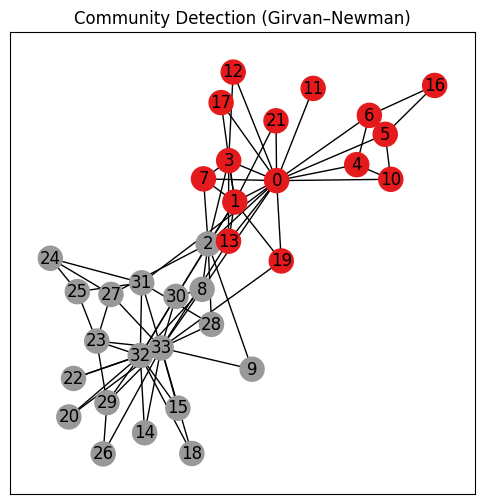

In [12]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt

# Karate Club 데이터 불러오기
G = nx.karate_club_graph()

# Girvan–Newman 알고리즘 적용 (edge betweenness 기반)
communities = community.girvan_newman(G)
first_level_communities = next(communities)
community_list = [list(c) for c in first_level_communities]

# 노드별 커뮤니티 라벨 만들기
node_colors = {}
for i, comm in enumerate(community_list):
    for node in comm:
        node_colors[node] = i

# 시각화
plt.figure(figsize=(6,6))
nx.draw_networkx(G, 
                 node_color=[node_colors[n] for n in G.nodes()],
                 with_labels=True, cmap=plt.cm.Set1)
plt.title("Community Detection (Girvan–Newman)")
plt.show()

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv

# 데이터셋 불러오기 (PyG 내장)
dataset = KarateClub()
data = dataset[0]

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# 학습 루프
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

print("Final Loss:", loss.item())
pred = out.argmax(dim=1)
print("Prediction:", pred)


Final Loss: 0.007527276873588562
Prediction: tensor([1, 1, 0, 1, 3, 3, 3, 1, 0, 0, 3, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 2,
        2, 2, 0, 2, 0, 0, 0, 2, 0, 0])


In [21]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8*8, dataset.num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

print("Final Loss (GAT):", loss.item())
pred = out.argmax(dim=1)
print("Prediction (GAT):", pred)


Final Loss (GAT): 0.2236003577709198
Prediction (GAT): tensor([1, 1, 0, 0, 3, 3, 3, 1, 0, 0, 3, 0, 0, 1, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 2, 0, 0])


In [ ]:
print("hello world")

hello world


In [5]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [ ]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GAE

# GCN
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GAT
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=4):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [9]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index).argmax(dim=1)
        correct = (pred == data.y).sum()
        acc = int(correct) / int(data.y.size(0))
    return acc

In [10]:
models = {
    "GCN": GCN(hidden_channels=16),
    "GAT": GAT(hidden_channels=8),
    "GraphSAGE": GraphSAGE(hidden_channels=16)
}

for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(50):
        loss = train(model, data, optimizer, criterion)

    acc = test(model, data)
    print(f"{name} 최종 정확도: {acc:.4f}")

GCN 최종 정확도: 0.9412
GAT 최종 정확도: 0.9706
GraphSAGE 최종 정확도: 1.0000


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


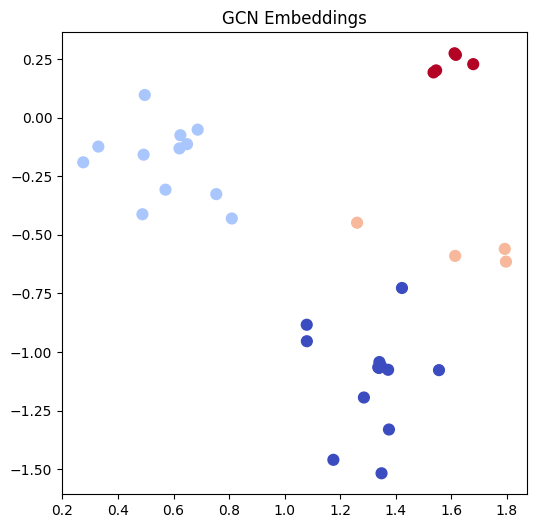

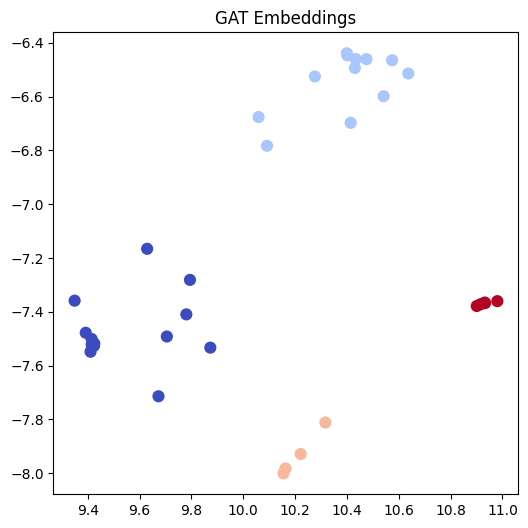

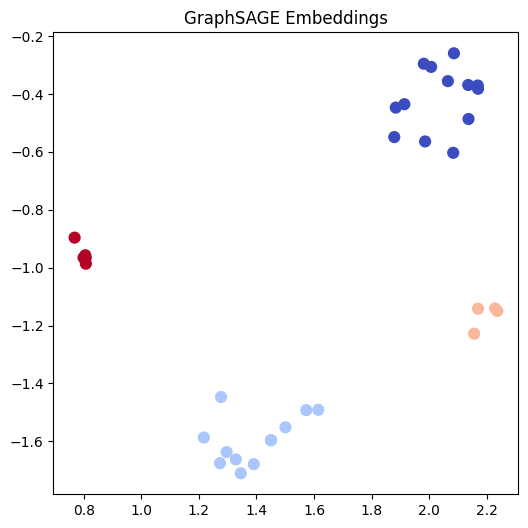

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -------------------
# 1. 데이터 준비
# -------------------
dataset = KarateClub()
data = dataset[0]
print(data)  # 노드 수, 피처 차원, 클래스 확인

# -------------------
# 2. 모델 정의
# -------------------
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=4):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# -------------------
# 3. 학습 함수
# -------------------
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
    return model

def visualize(embeddings, labels, title):
    z = TSNE(n_components=2).fit_transform(embeddings.detach().cpu().numpy())
    plt.figure(figsize=(6,6))
    plt.scatter(z[:,0], z[:,1], c=labels, cmap="coolwarm", s=60)
    plt.title(title)
    plt.show()

# -------------------
# 4. 모델별 학습 및 시각화
# -------------------
criterion = nn.CrossEntropyLoss()

# GCN
gcn = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
gcn = train(gcn, data, optimizer, criterion)
gcn.eval()
with torch.no_grad():
    gcn_emb = gcn(data.x, data.edge_index)
visualize(gcn_emb, data.y, "GCN Embeddings")

# GAT
gat = GAT(hidden_channels=8, heads=4)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.01)
gat = train(gat, data, optimizer, criterion)
gat.eval()
with torch.no_grad():
    gat_emb = gat(data.x, data.edge_index)
visualize(gat_emb, data.y, "GAT Embeddings")

# GraphSAGE
sage = GraphSAGE(hidden_channels=16)
optimizer = torch.optim.Adam(sage.parameters(), lr=0.01)
sage = train(sage, data, optimizer, criterion)
sage.eval()
with torch.no_grad():
    sage_emb = sage(data.x, data.edge_index)
visualize(sage_emb, data.y, "GraphSAGE Embeddings")

### 비지도학습 방식을 활용 : GAE(Graph AutoEncoder)

In [15]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GAE

In [16]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# GCN 기반 GAE 모델 생성
gcn_encoder = GCNEncoder(dataset.num_features, 16)
gcn_gae = GAE(gcn_encoder)

In [17]:
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=2):
        super().__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=heads)
        self.conv2 = GATConv(2 * out_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# GAT 기반 GAE 모델 생성
gat_encoder = GATEncoder(dataset.num_features, 16)
gat_gae = GAE(gat_encoder)

In [18]:
class SAGEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, 2 * out_channels)
        self.conv2 = SAGEConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# GraphSAGE 기반 GAE 모델 생성
sage_encoder = SAGEEncoder(dataset.num_features, 16)
sage_gae = GAE(sage_encoder)

In [19]:
from torch_geometric.utils import train_test_split_edges

# train/val/test 분리
data = train_test_split_edges(data)

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)  # 인접행렬 복원 손실
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

c:\Users\user\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [20]:
models = {
    "GCN-GAE": gcn_gae,
    "GAT-GAE": gat_gae,
    "SAGE-GAE": sage_gae
}

for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(100):
        loss = train(model, data, optimizer)
    auc, ap = test(model, data)
    print(f"{name} - AUC: {auc:.4f}, AP: {ap:.4f}")

GCN-GAE - AUC: 0.7959, AP: 0.8810
GAT-GAE - AUC: 0.7347, AP: 0.7878
SAGE-GAE - AUC: 0.8367, AP: 0.9082
